### Necessary imports

In [4]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

### Hyperparameters

In [5]:
sequence_length = 5
input_size = 15
extra_size = 5
batch = 32
hidden_size = 512
num_layers = 1
num_epochs = 500
learning_rate = 0.1

### Generate samples

In [6]:
def add_vec(x,y):
    tmp = 0
    z = np.zeros(len(x),dtype=int)
    for i in reversed(range(len(x))):
        if x[i] == 0 and y[i] == 0:
            z[i] = tmp
            tmp = 0
        elif x[i] == 1 and y[i] == 1:
            z[i] = tmp
            tmp = 1
        else:
            z[i] = 1-tmp
    return z


def generate_output(input_data):
    output_data = np.zeros(input_data.shape,dtype = int)
    for i in range(sequence_length):
        for j in range(batch):
            if i == 0:
                output_data[i][j] = input_data[i][j]
            else:
                output_data[i][j] = add_vec(output_data[i-1][j],input_data[i][j])
    return output_data

def generate():
    input_data = np.random.randint(2, size=(sequence_length, batch ,input_size))
    input_data = np.concatenate((np.zeros((sequence_length, batch, extra_size)),input_data), axis=2)
    output_data = generate_output(input_data)
    x = Variable(torch.from_numpy(input_data)).float()
    y = Variable(torch.from_numpy(output_data)).float()
    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()
    return x, y

### Neural Network

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size+extra_size, hidden_size, num_layers)
        self.fc = nn.Linear(sequence_length*hidden_size, sequence_length*(input_size+extra_size))
    
    def forward(self, x):
        # Forward propagate RNN
        (h0, c0) = self.init_hidden_state()
        out, (h0, c0) = self.lstm(x, (h0, c0)) 
        out = self.fc(out.view(-1,sequence_length*hidden_size))
        out = F.sigmoid(out)
        return out
    
    def init_hidden_state(self):
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.num_layers, batch, self.hidden_size).cuda()) 
            c0 = Variable(torch.zeros(self.num_layers, batch, self.hidden_size).cuda())
        else:
            h0 = Variable(torch.zeros(self.num_layers, batch, self.hidden_size)) 
            c0 = Variable(torch.zeros(self.num_layers, batch, self.hidden_size))
        return h0, c0

rnn = RNN(input_size, hidden_size, num_layers)
if torch.cuda.is_available():
    rnn.cuda()

### Test

In [8]:
x,y = generate()
out = rnn(x)

# print(out)

### Loss and optimizer

In [9]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

In [10]:
def accuracy(y,out):
    y = y.data.numpy()
    out = out.data.numpy()
    out = np.round(out)
    return 1 - (sum(sum(abs(y-out))))/((input_size+extra_size)*sequence_length*batch)

### Train

In [12]:
losses = np.zeros(num_epochs)
acc = np.zeros(num_epochs)
last_time = time.time()
for i in range(num_epochs):
    rnn.zero_grad()
    x,y = generate()
    out = rnn(x)
    y = torch.transpose(y,0,1)
    y = y.contiguous()
    y = y.view(batch,-1)
    y = y[:,20:]
    out = out[:,20:]
    loss = criterion(out,y)
    losses[i] = loss.data[0]
    acc[i] = accuracy(out,y)
    loss.backward()
    optimizer.step()
    if (i+1)%(num_epochs//20) == 0:
        print('Step '+ str(i+1) + '/' +str(num_epochs)+ ' done. Loss = ' + \
              str(losses[i])+ '. Accuracy = ' + str(acc[i]) + '. Time elapsed: ' + str(time.time()-last_time))
        last_time = time.time()
        

Step 25/500 done. Loss = 14.5604400635. Accuracy = 0.565794648081. Time elapsed: 1.778245210647583
Step 50/500 done. Loss = 11.3366594315. Accuracy = 0.659047167897. Time elapsed: 2.2563822269439697
Step 75/500 done. Loss = 10.9062852859. Accuracy = 0.670130518973. Time elapsed: 2.858313798904419
Step 100/500 done. Loss = 10.9098539352. Accuracy = 0.672849192023. Time elapsed: 2.642841100692749
Step 125/500 done. Loss = 11.0685138702. Accuracy = 0.671997626424. Time elapsed: 2.394167900085449
Step 150/500 done. Loss = 10.8566789627. Accuracy = 0.679550363123. Time elapsed: 2.230984926223755
Step 175/500 done. Loss = 11.280919075. Accuracy = 0.669119748771. Time elapsed: 2.161612033843994
Step 200/500 done. Loss = 11.1599779129. Accuracy = 0.672427907586. Time elapsed: 2.088521957397461
Step 225/500 done. Loss = 11.2502355576. Accuracy = 0.669761740565. Time elapsed: 2.106377124786377
Step 250/500 done. Loss = 11.0943307877. Accuracy = 0.675890580416. Time elapsed: 2.1815829277038574
St

### Plots

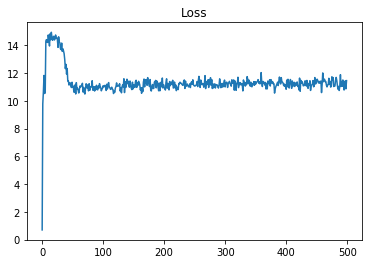

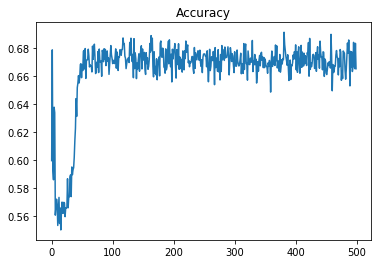

In [13]:
%matplotlib inline
plt.plot(losses)
plt.title('Loss')
plt.figure()
plt.plot(acc)
plt.title('Accuracy')

### Test accuracy

In [ ]:
x,y = generate()
out = rnn(x)
print(accuracy(out,y))


In [ ]:
i